## Importing Libraries

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_recall_fscore_support



from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)


## Loading and Initial Exploration of the Obesity Dataset

In [9]:
df = pd.read_csv("ObesityDataSet.csv")

print("✅ Loaded Successfully!")
print("Shape (rows, cols):", df.shape)

print("\nColumns:")
print(df.columns.tolist())

print("\nFirst 5 rows:")
display(df.head())



✅ Loaded Successfully!
Shape (rows, cols): (2111, 17)

Columns:
['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad']

First 5 rows:


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## Missing Value Analysis in the Obesity Dataset

In [12]:
print("Total missing values:", df.isna().sum().sum())

print("\nMissing values per column:")
df.isna().sum()

Total missing values: 0

Missing values per column:


Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

## Handling Duplicate Rows in the Dataset

In [15]:
print("Duplicates:", df.duplicated().sum())

df = df.drop_duplicates()
print("After removing duplicates:", df.shape)



Duplicates: 24
After removing duplicates: (2087, 17)


## Zero-Value Analysis in Numerical Features

In [18]:
num_cols = df.select_dtypes(include=["int64","float64"]).columns
zero_counts = (df[num_cols] == 0).sum()
print(zero_counts[zero_counts > 0])

FAF    405
TUE    537
dtype: int64


## Handling Invalid Zero Values in Key Numerical Features

In [21]:
for col in ["Age","Height","Weight"]:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)


## Handling Missing Data Using Median and Mode Imputation

In [24]:
num_cols = df.select_dtypes(include=["int64","float64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

# numeric → median
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# categorical → mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("Missing now:", df.isna().sum().sum())


Missing now: 0


## Visualization of Target Variable Frequencies

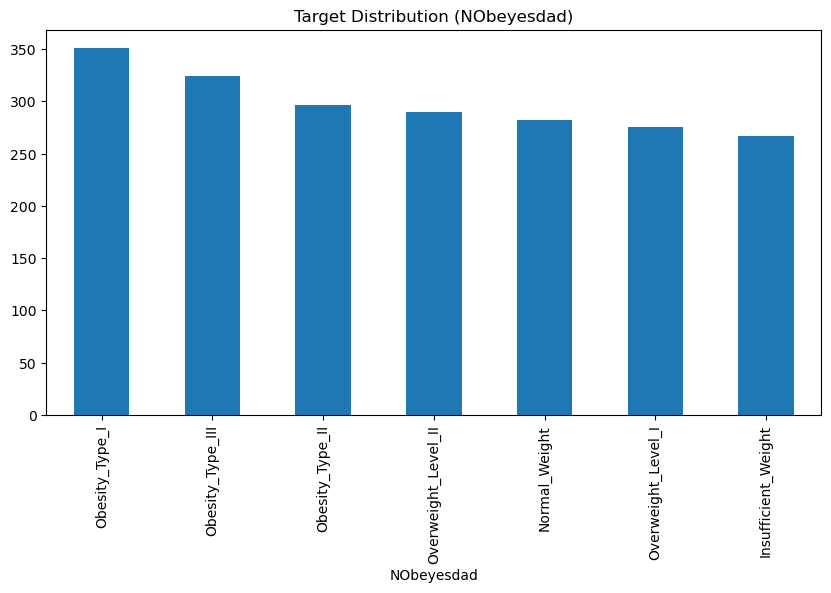

In [27]:
target = "NObeyesdad"
df[target].value_counts()
plt.figure(figsize=(10,5))
df[target].value_counts().plot(kind="bar")
plt.title("Target Distribution (NObeyesdad)")
plt.show()


## Histogram Visualization of Numeric Attributes

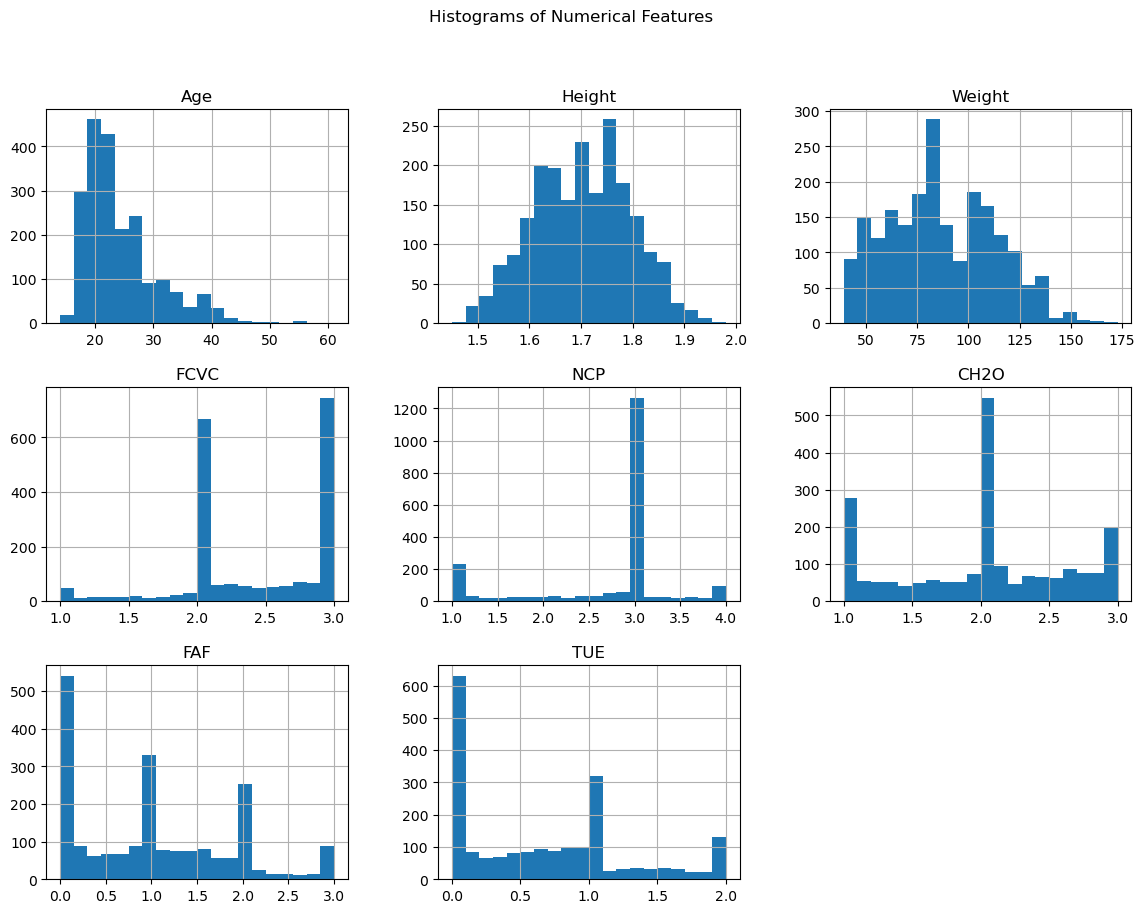

In [30]:
df[num_cols].hist(figsize=(14,10), bins=20)
plt.suptitle("Histograms of Numerical Features")
plt.show()


## Correlation Analysis of Numerical Features Using a Heatmap

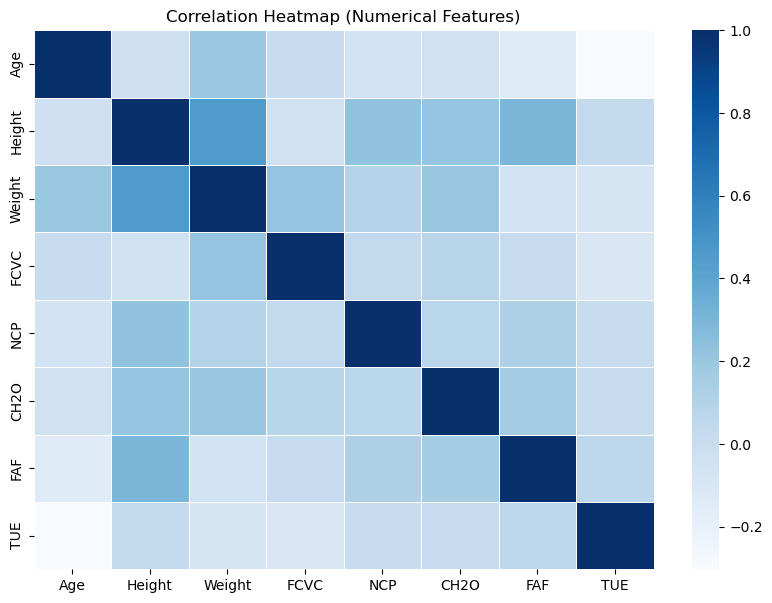

In [35]:
# Compute correlation matrix
corr = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(10,7))
sns.heatmap(
    corr,
    cmap="Blues",
    annot=False,
    linewidths=0.5,
    linecolor="white"
)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


## Separating Features and Target Variable for Modeling

In [38]:
X = df.drop(columns=[target])
y = df[target]


## Splitting Dataset into Training and Testing Sets

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape)


(1669, 16) (418, 16)


## Preprocessing Pipeline: Scaling Numerical and Encoding Categorical Features

In [44]:
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


## Model Training, Evaluation, and Performance Comparison

In [47]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7)
}

results = []
preds_store = {}

for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocessor), ("model", clf)])
    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)
    preds_store[name] = pred

    acc = accuracy_score(y_test, pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, pred, average="weighted", zero_division=0)
    results.append([name, acc, p, r, f1])

results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1"])
results_df.sort_values("Accuracy", ascending=False)


,Model,Accuracy,Precision,Recall,F1
2,Random Forest,0.942584,0.946764,0.942584,0.943608
1,Decision Tree,0.933014,0.933970,0.933014,0.932594
0,Logistic Regression,0.897129,0.894974,0.897129,0.895354
3,KNN,0.803828,0.795135,0.803828,0.782262


## Comparison of Model Accuracies

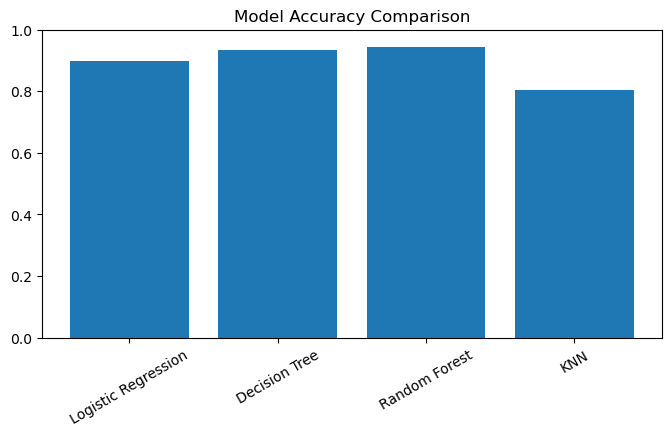

In [50]:
plt.figure(figsize=(8,4))
plt.bar(results_df["Model"], results_df["Accuracy"])
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=30)
plt.ylim(0,1)
plt.show()


## Identifying the Best Performing Model

In [53]:
best_model = results_df.sort_values("Accuracy", ascending=False).iloc[0]["Model"]
print("Best model ✅:", best_model)


Best model ✅: Random Forest


## Confusion Matrix for the Best Performing Model

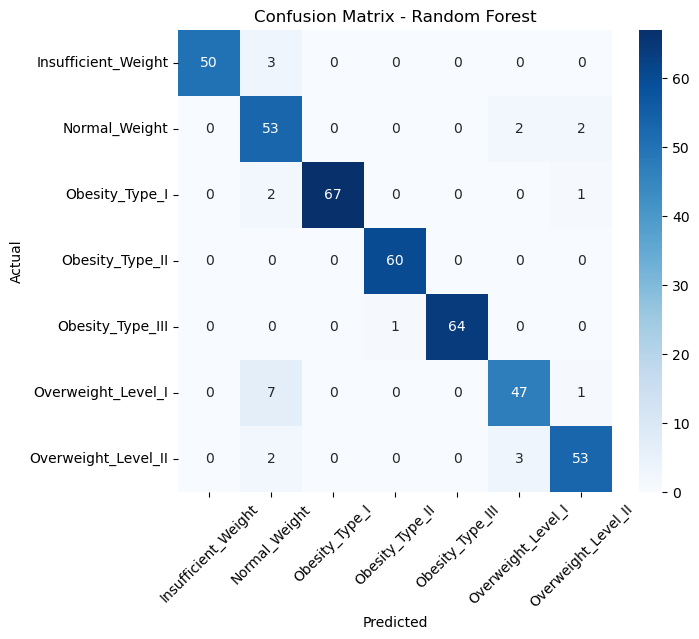

In [56]:
labels = np.unique(y_test)

best_pred = preds_store[best_model]
cm = confusion_matrix(y_test, best_pred, labels=labels)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title(f"Confusion Matrix - {best_model}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.show()


## Making Predictions for New User Data Using the Best Model

In [59]:
# Refit best pipeline
best_pipe = Pipeline(steps=[("prep", preprocessor), ("model", models[best_model])])
best_pipe.fit(X_train, y_train)

new_user = {}
for col in X.columns:
    val = input(f"Enter {col}: ")
    if col in num_cols:
        new_user[col] = float(val)
    else:
        new_user[col] = str(val)

new_df = pd.DataFrame([new_user])
print("Predicted obesity class:", best_pipe.predict(new_df)[0])


Enter Gender:  Female
Enter Age:  25
Enter Height:  4.8
Enter Weight:  70
Enter family_history_with_overweight:  yes
Enter FAVC:  yes
Enter FCVC:  2
Enter NCP:  3
Enter CAEC:  Sometimes
Enter SMOKE:  No
Enter CH2O:  2
Enter SCC:  No
Enter FAF:  1
Enter TUE:  1
Enter CALC:  Sometimes
Enter MTRANS:  Public_Transporation


Predicted obesity class: Overweight_Level_I
